In [1]:
cd ..

/home/yann/IVISpaces


In [2]:
import numpy as np
import math
import torch
from torch import nn

from torch.distributions.multivariate_normal import MultivariateNormal


import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt

from Models import BigGenerator

from datetime import datetime

from torch.utils.data import Dataset

from Models import get_mlp
from Tools import NormalLogLikelihood
from Metrics import KL, evaluate_metrics, Entropy

from Experiments import get_setup

from Inference.IVI import IVI

from tqdm import trange

import timeit

In [83]:
#hyperparameters

#predictive model
layerwidth=50
nblayers=1
activation=nn.Tanh()

#generative model
lat_dim=5



#optimizer
learning_rate=0.01

#scheduler
patience=30
lr_decay=.5#.7
min_lr= 0.0001
n_epochs=1000#2000


#loss hyperparameters
n_samples_LL=100 #nb of predictor samples for average LogLikelihood

n_samples_KL=200 #nb of predictor samples for KL divergence
kNNE=1 #k-nearest neighbour



In [84]:

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

date_string = datetime.now().strftime("%Y-%m-%d-%H:%M")

# Setup #

42.03654647827148 6.939390586993748


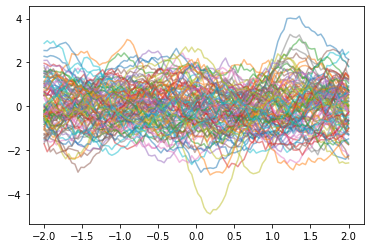

In [85]:
class GaussianProcess(nn.Module):
    def __init__(self, mean, lengthscale, noise=0.05):
        super(GaussianProcess, self).__init__()
        self.ls=lengthscale
        self.mean=mean
        self.var=noise**2

    def covar_matrix(self,x):
        K=torch.cdist(x.div(self.ls),x.div(self.ls),p=2).pow_(2).div_(-2).exp_()
        return K+self.var*torch.eye(x.shape[0], device=x.device)##
    
    def log_prob(self,inputs,f):
        GP_inputs=MultivariateNormal(loc=self.mean*torch.ones(inputs.shape[0], device=inputs.device),covariance_matrix=self.covar_matrix(inputs))
        return GP_inputs.log_prob(f)
    def forward(self, inputs, n=1):
        GP_inputs=MultivariateNormal(loc=self.mean*torch.ones(inputs.shape[0], device=inputs.device),covariance_matrix=self.covar_matrix(inputs))
        return GP_inputs.sample((n,)).squeeze()
    
prior=GaussianProcess(mean=torch.tensor(0.),lengthscale=.3, noise=0.1)    
inputs=torch.linspace(-2,2.,100).unsqueeze(-1).to(device)
LPs=[]

for _ in range(100):
    f=prior(inputs).cpu()
    plt.plot(inputs.cpu(),f.cpu(),alpha=0.5)
    LPs.append(prior.log_prob(inputs.cpu(),f).item())
print(np.mean(LPs),np.std(LPs))   

In [86]:
#UCI datasets: ['boston','concrete', 'energy', 'powerplant',  'wine', 'yacht']
dataset='foong' 

setup_ = get_setup(dataset)
setup=setup_.Setup(device) 

x_train, y_train=setup.train_data()
x_test, y_test=setup.test_data()

train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
test_dataset = torch.utils.data.TensorDataset(x_test, y_test)
train_input = torch.utils.data.TensorDataset(x_train)

sigma_noise=setup.sigma_noise
print(sigma_noise)
sigma_prior=1.#setup.sigma_prior    

size_data=len(train_dataset)
#batch_size
batch_size=30


n_samples_FU=30 #number of OOD inputs for evaluation of the KL in predictor space
n_train_input_samples_KL=0 #must be lower or equal to batch_size

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


std_y_train = torch.tensor(1.)
if hasattr(setup, '_scaler_y'):
    std_y_train=torch.tensor(setup._scaler_y.scale_, device=device).squeeze().float()

0.1


# Predictive model #

In [63]:
input_dim=x_train.shape[1]
param_count, model = get_mlp(input_dim, layerwidth, nblayers, activation)

print('input dim: '+str(input_dim))
print('param count: '+str(param_count))

input dim: 1
param count: 151


# ELBO

## Average Log Likelihood

In [64]:
#average log likelihood loss
def loss(x_data, y_data, GeN):
    r"""

    Parameters:
    x_data (Tensor): tensor of size N X D
    y_data (Tensor): tensor of size N X 1
    GeN: hypernet generating weights for primary network 'model'


    Returns:
    (float):   mean of loglikelihood
    """

    y_pred=model(x_data,GeN(n_samples_LL))
    log_proba=NormalLogLikelihood(y_pred, y_data, sigma_noise).sum(1)
    return log_proba.mean()

## Kullback-Leibler divergence in Predictor space

In [87]:

# sampling of OOD inputs on which evaluate predictors for the Hilbert distance
"""
##for toy example
n_samples_FU=30
def projection(theta0,theta1):
    #batch sample OOD    
    M=2.
    m=-2.
    X_ood = torch.rand(n_samples_FU,input_dim).to(device) * (M-m) + m    
    X=X_ood
    #compute projection on both paramters with model
    theta0_proj=model(X, theta0).squeeze(2)
    theta1_proj=model(X, theta1).squeeze(2)
    return theta0_proj, theta1_proj
"""
#predictor space KL
def projection(theta0,theta1, x_data):
    #batch sample OOD   
    n_ood=n_samples_FU
#    epsilon=0.1
    M = 2.#x_train.max(0, keepdim=True)[0]+epsilon
    m = -2.#x_train.min(0, keepdim=True)[0]-epsilon
    X_ood = torch.rand(n_ood,input_dim).to(device) * (M-m) + m    

    X=torch.cat([X_ood,x_data[:n_train_input_samples_KL,:]])
    
    #compute projection on both paramters with model
    theta0_proj=model(X, theta0).squeeze(2)
    theta1_proj=model(X, theta1).squeeze(2)
    return theta0_proj, theta1_proj

def projection_train(theta0,theta1,x_data):
    #batch sample OOD

    #compute projection on both paramters with model
    theta0_proj=model(x_data, theta0).squeeze(2)
    theta1_proj=model(x_data, theta1).squeeze(2)
    return theta0_proj, theta1_proj

def ood_input(n_ood=30):
    M =4.
    m =-4.
    return torch.rand(n_ood,input_dim).to(device) * (M-m) + m  


def kl(GeN):
    theta=GeN(n_samples_KL) #variationnel
    X_ood=ood_input()
    f_theta=model(X_ood, theta).squeeze(2)
    f_prior=prior(X_ood,n=n_samples_KL)
    k=KL(f_theta,f_prior,k=kNNE,device=device)
    return k


def kl_(GeN):
    theta=GeN(n_samples_KL) #variationnel
    n_ood=50
    X_ood=ood_input()
    f_theta=model(X_ood, theta).squeeze(2)
    H=Entropy(f_theta,k_MC=n_ood)
    logtarget=prior.log_prob(X_ood,f_theta).mean()
    return -H-logtarget


def kl_train(GeN,x_data):

    theta=GeN(x_data.shape[0]) #variationnel
    theta_prior=prior(x_data.shape[0]) #prior

    theta_proj, theta_prior_proj = projection_train(theta, theta_prior,x_data)

    K=KL(theta_proj, theta_prior_proj,k=kNNE,device=device)
    return K

models_HMC = torch.load('Results/HMC_models.pt')
HMC=models_HMC[dataset][:500,:].to(device)
def kl_HMC_train(GeN,x_data):

    theta=GeN(HMC.shape[0]) #variationnel

    theta_proj, theta_HMC_proj = projection_train(theta, HMC ,x_data)

    K=KL(theta_proj, theta_HMC_proj,k=kNNE,device=device)
    return K

def kl_HMC_OOD(GeN):

    theta=GeN(HMC.shape[0]) #variationnel

    theta_proj, theta_HMC_proj = projection(theta, HMC, torch.empty((0,input_dim)).to(device))

    K=KL(theta_proj, theta_HMC_proj,k=kNNE,device=device)
    return K

## ELBO ##

In [88]:
#ELBO

beta=1.
def ELBO(x_data, y_data, GeN, beta=beta):
    alpha=(len(x_data)/size_data)
    Average_LogLikelihood=loss(x_data, y_data, GeN)
    the_KL=kl_(GeN)
    the_ELBO= - Average_LogLikelihood+ alpha*the_KL
    return the_ELBO, the_KL, Average_LogLikelihood 


# Generative model #

In [89]:
#generative model
GeN = BigGenerator(lat_dim,param_count,device).to(device)
print(GeN)

BigGenerator(
  (model): Sequential(
    (0): Linear(in_features=5, out_features=20, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=20, out_features=40, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=40, out_features=151, bias=True)
  )
)


# Optimizer

In [90]:
optimizer = torch.optim.Adam(GeN.parameters(), lr=learning_rate)

Run=IVI(train_loader, ELBO, optimizer)

# Scheduler #

In [91]:
#scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=patience, factor=lr_decay, verbose=True, min_lr=min_lr)


# TRAINING #

In [92]:
KLs=[]
ELBOs=[]
LLs=[]
LRs=[]

test_metrics={'RMSE':[],
              'PICP':[],
              'MPIW':[],
              'LPP':[],
              'WAIC':[],
              'KL_train':[],
              'HMC_OOD':[],
              'HMC_train':[]
             }
start = timeit.default_timer()
with trange(n_epochs) as tr:
    for t in tr:
        
        theta=GeN(1000).detach()
        y_pred=model(x_test,theta)
        metrics=evaluate_metrics(y_pred, torch.tensor(sigma_noise).view(1,1,1), y_test,  std_y_train, device='cpu', std=False)
        
        for m,v in metrics.items():
            test_metrics[m].append(v)
        
        scores=Run.run(GeN)
        tr.set_postfix(ELBO=scores['ELBO'], LogLike=scores['LL'], KL=scores['KL'], lr=scores['lr'])
        ELBOs.append(scores['ELBO'])
        KLs.append(scores['KL'])
        LLs.append(scores['LL'])
        LRs.append(scores['lr'])
        scheduler.step(scores['ELBO'])
        if scores['lr'] <= 1e-4:
            break
stop = timeit.default_timer()
execution_time = stop - start



 18%|█▊        | 179/1000 [01:15<03:43,  3.68it/s, ELBO=18.2, KL=101, LogLike=6.89, lr=0.01] 

Epoch   179: reducing learning rate of group 0 to 5.0000e-03.


 28%|██▊       | 284/1000 [01:59<04:36,  2.59it/s, ELBO=6.08, KL=98.2, LogLike=18.5, lr=0.005]

Epoch   284: reducing learning rate of group 0 to 2.5000e-03.


 40%|███▉      | 399/1000 [02:51<04:20,  2.31it/s, ELBO=0.242, KL=88.1, LogLike=21.8, lr=0.0025]  

Epoch   399: reducing learning rate of group 0 to 1.2500e-03.


 47%|████▋     | 473/1000 [03:23<03:27,  2.54it/s, ELBO=-2.83, KL=81.5, LogLike=23.2, lr=0.000625] 

Epoch   472: reducing learning rate of group 0 to 6.2500e-04.


 56%|█████▌    | 559/1000 [04:01<03:10,  2.32it/s, ELBO=-4.15, KL=74.3, LogLike=22.7, lr=0.000625]

Epoch   559: reducing learning rate of group 0 to 3.1250e-04.


 60%|█████▉    | 598/1000 [04:18<02:57,  2.27it/s, ELBO=-4.83, KL=74.2, LogLike=23.4, lr=0.000313]

Epoch   598: reducing learning rate of group 0 to 1.5625e-04.


 63%|██████▎   | 629/1000 [04:32<02:39,  2.32it/s, ELBO=-4.5, KL=76.3, LogLike=23.6, lr=0.000156] 

Epoch   629: reducing learning rate of group 0 to 1.0000e-04.


 63%|██████▎   | 629/1000 [04:33<02:41,  2.30it/s, ELBO=-3.62, KL=78.8, LogLike=23.3, lr=0.0001] 


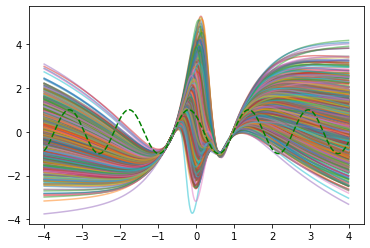

In [93]:
inputs=torch.linspace(-4.,4.,500).unsqueeze(-1).to(device)
for _ in range(1000):
    f=model(inputs,GeN(1)).squeeze().detach().cpu()
    plt.plot(inputs.cpu(),model(inputs,GeN(1)).squeeze().detach().cpu(),alpha=0.5)
plt.plot(inputs.cpu(), torch.cos(4.0*(inputs+0.2)).cpu(),'--',color='green')


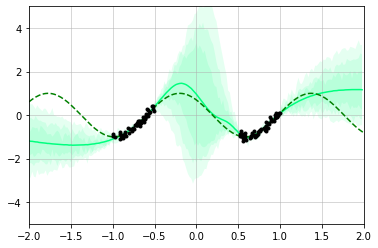

In [94]:
%matplotlib inline
fig=setup.makePlotCI(GeN(1000).detach(),device,sigma_noise)
ax=fig.get_axes()[0]
linspace=torch.linspace(-2,2,200)
ax.plot(linspace, torch.cos(4.0*(linspace+0.2)),'--',color='green')


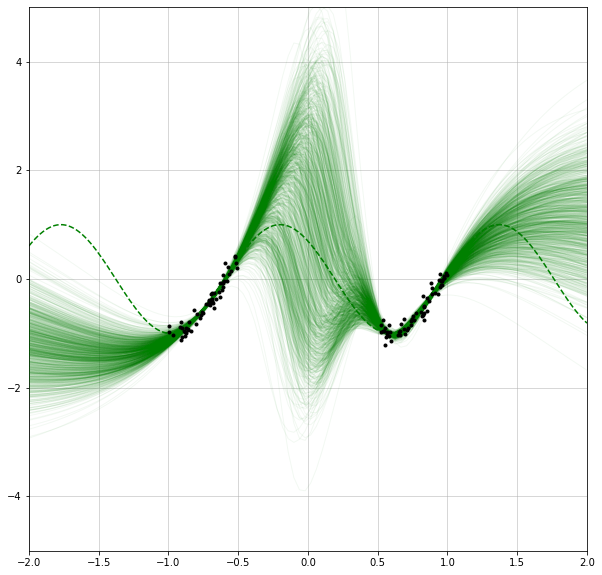

In [95]:
%matplotlib inline
fig=setup.makePlot(GeN(1000).detach(),device)
ax=fig.get_axes()[0]
linspace=torch.linspace(-2,2,200)
ax.plot(linspace, torch.cos(4.0*(linspace+0.2)),'--', color='green')


# Results on test #

In [96]:
#compute metrics on test

results={}
log_device='cpu'
theta=GeN(2000).detach()
y_pred=model(x_test,theta)
metrics=evaluate_metrics(y_pred, torch.tensor(sigma_noise).view(1,1,1), y_test,  std_y_train, device='cpu', std=False)
results.update({dataset:metrics})
results[dataset].update({'time [s]':execution_time})

print(dataset)
for m, r in metrics.items():
    print(m+': '+str(r))

foong
RMSE: 0.9834916591644287
LPP: -8.77856159210205
WAIC: -4445.940670967102
PICP: 0.6850000023841858
MPIW: 1.6294869184494019
time [s]: 273.09124660003


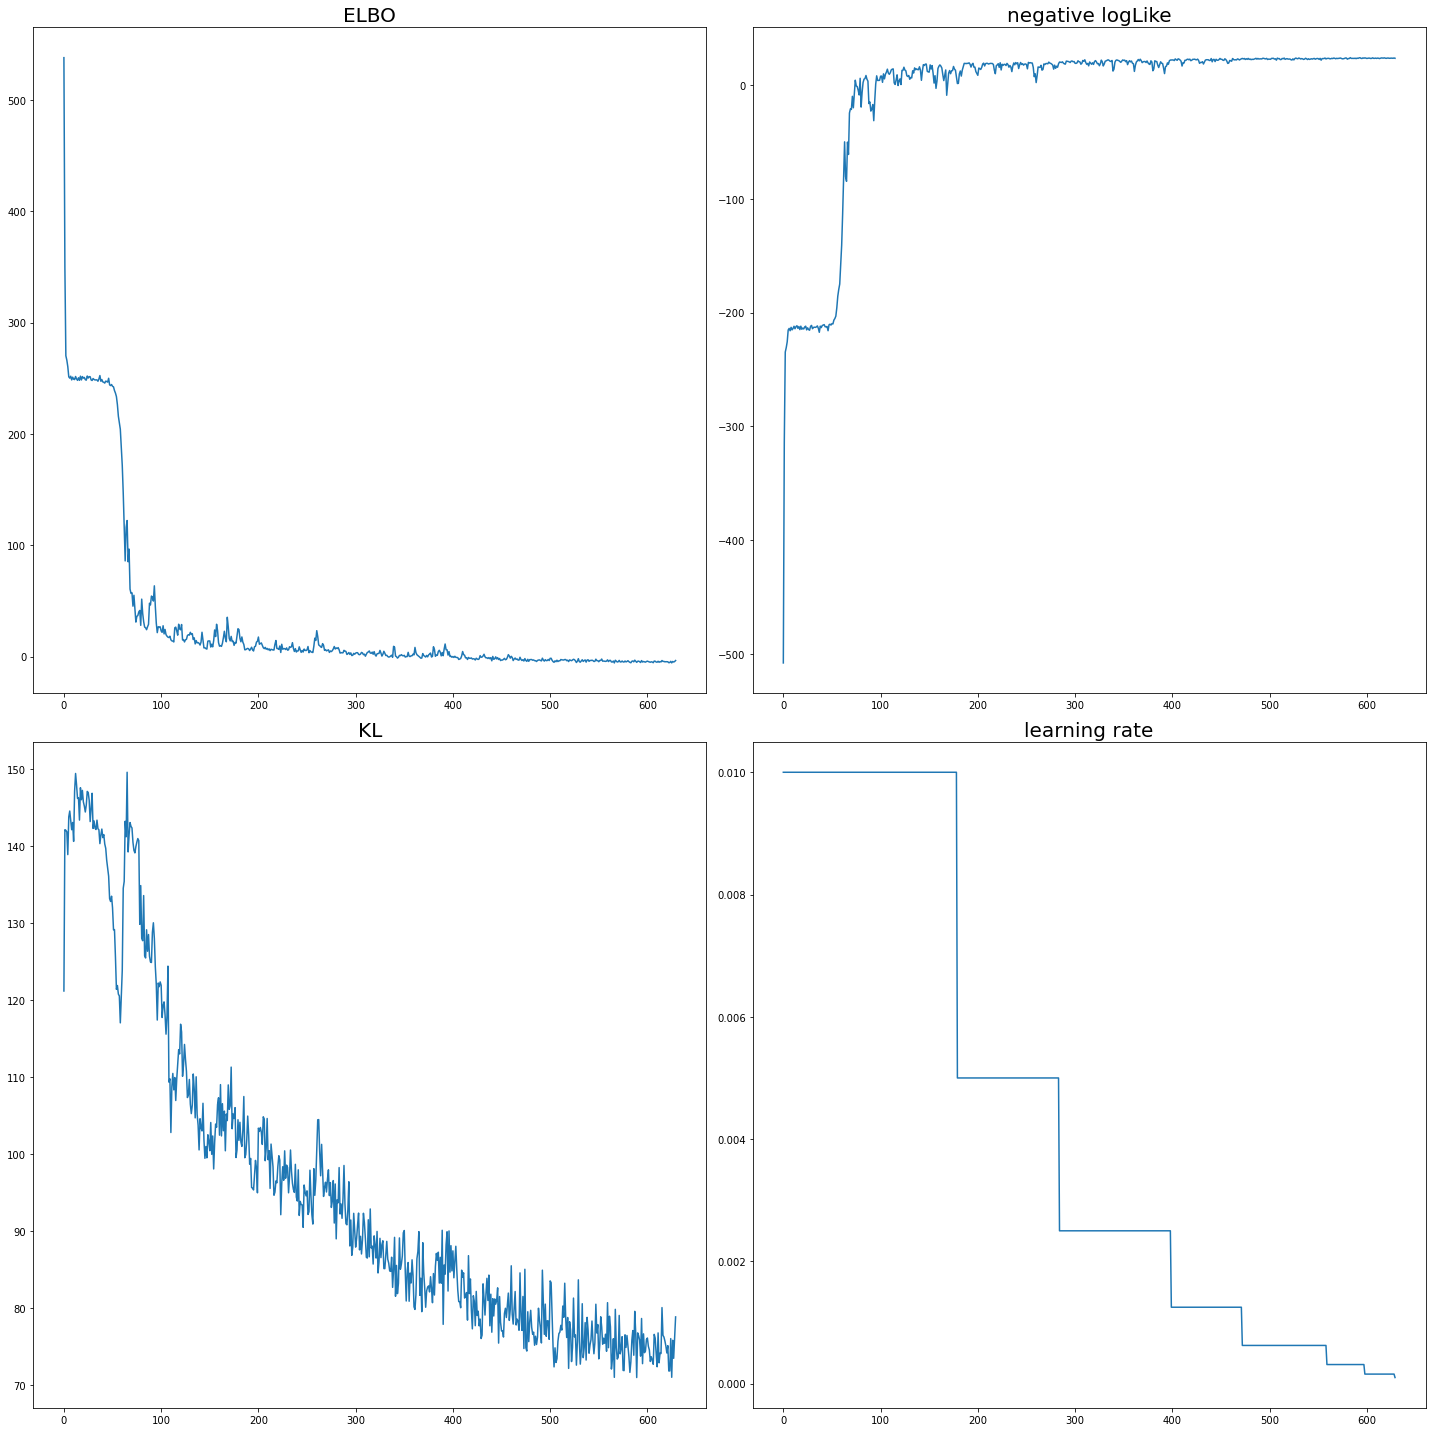

In [97]:
training={'ELBO':ELBOs,'KL':KLs, 'LR':LRs, 'LL':LLs}
time_line=torch.arange(0,len(training['ELBO']),1)

ELBO_=torch.as_tensor(training['ELBO'])
KL_=torch.as_tensor(training['KL'])
LR_=torch.as_tensor(training['LR'])
LL_=torch.as_tensor(training['LL'])

fig, ax =plt.subplots(2,2, figsize=(20,20))
ax[0,0].plot(time_line,ELBO_)
ax[0,0].set_title('ELBO', fontsize=20)
ax[0,1].plot(time_line,LL_)
ax[0,1].set_title('negative logLike', fontsize=20)
ax[1,0].plot(time_line,KL_)
ax[1,0].set_title('KL', fontsize=20)
ax[1,1].plot(time_line,LR_)
ax[1,1].set_title('learning rate', fontsize=20)
fig.tight_layout()

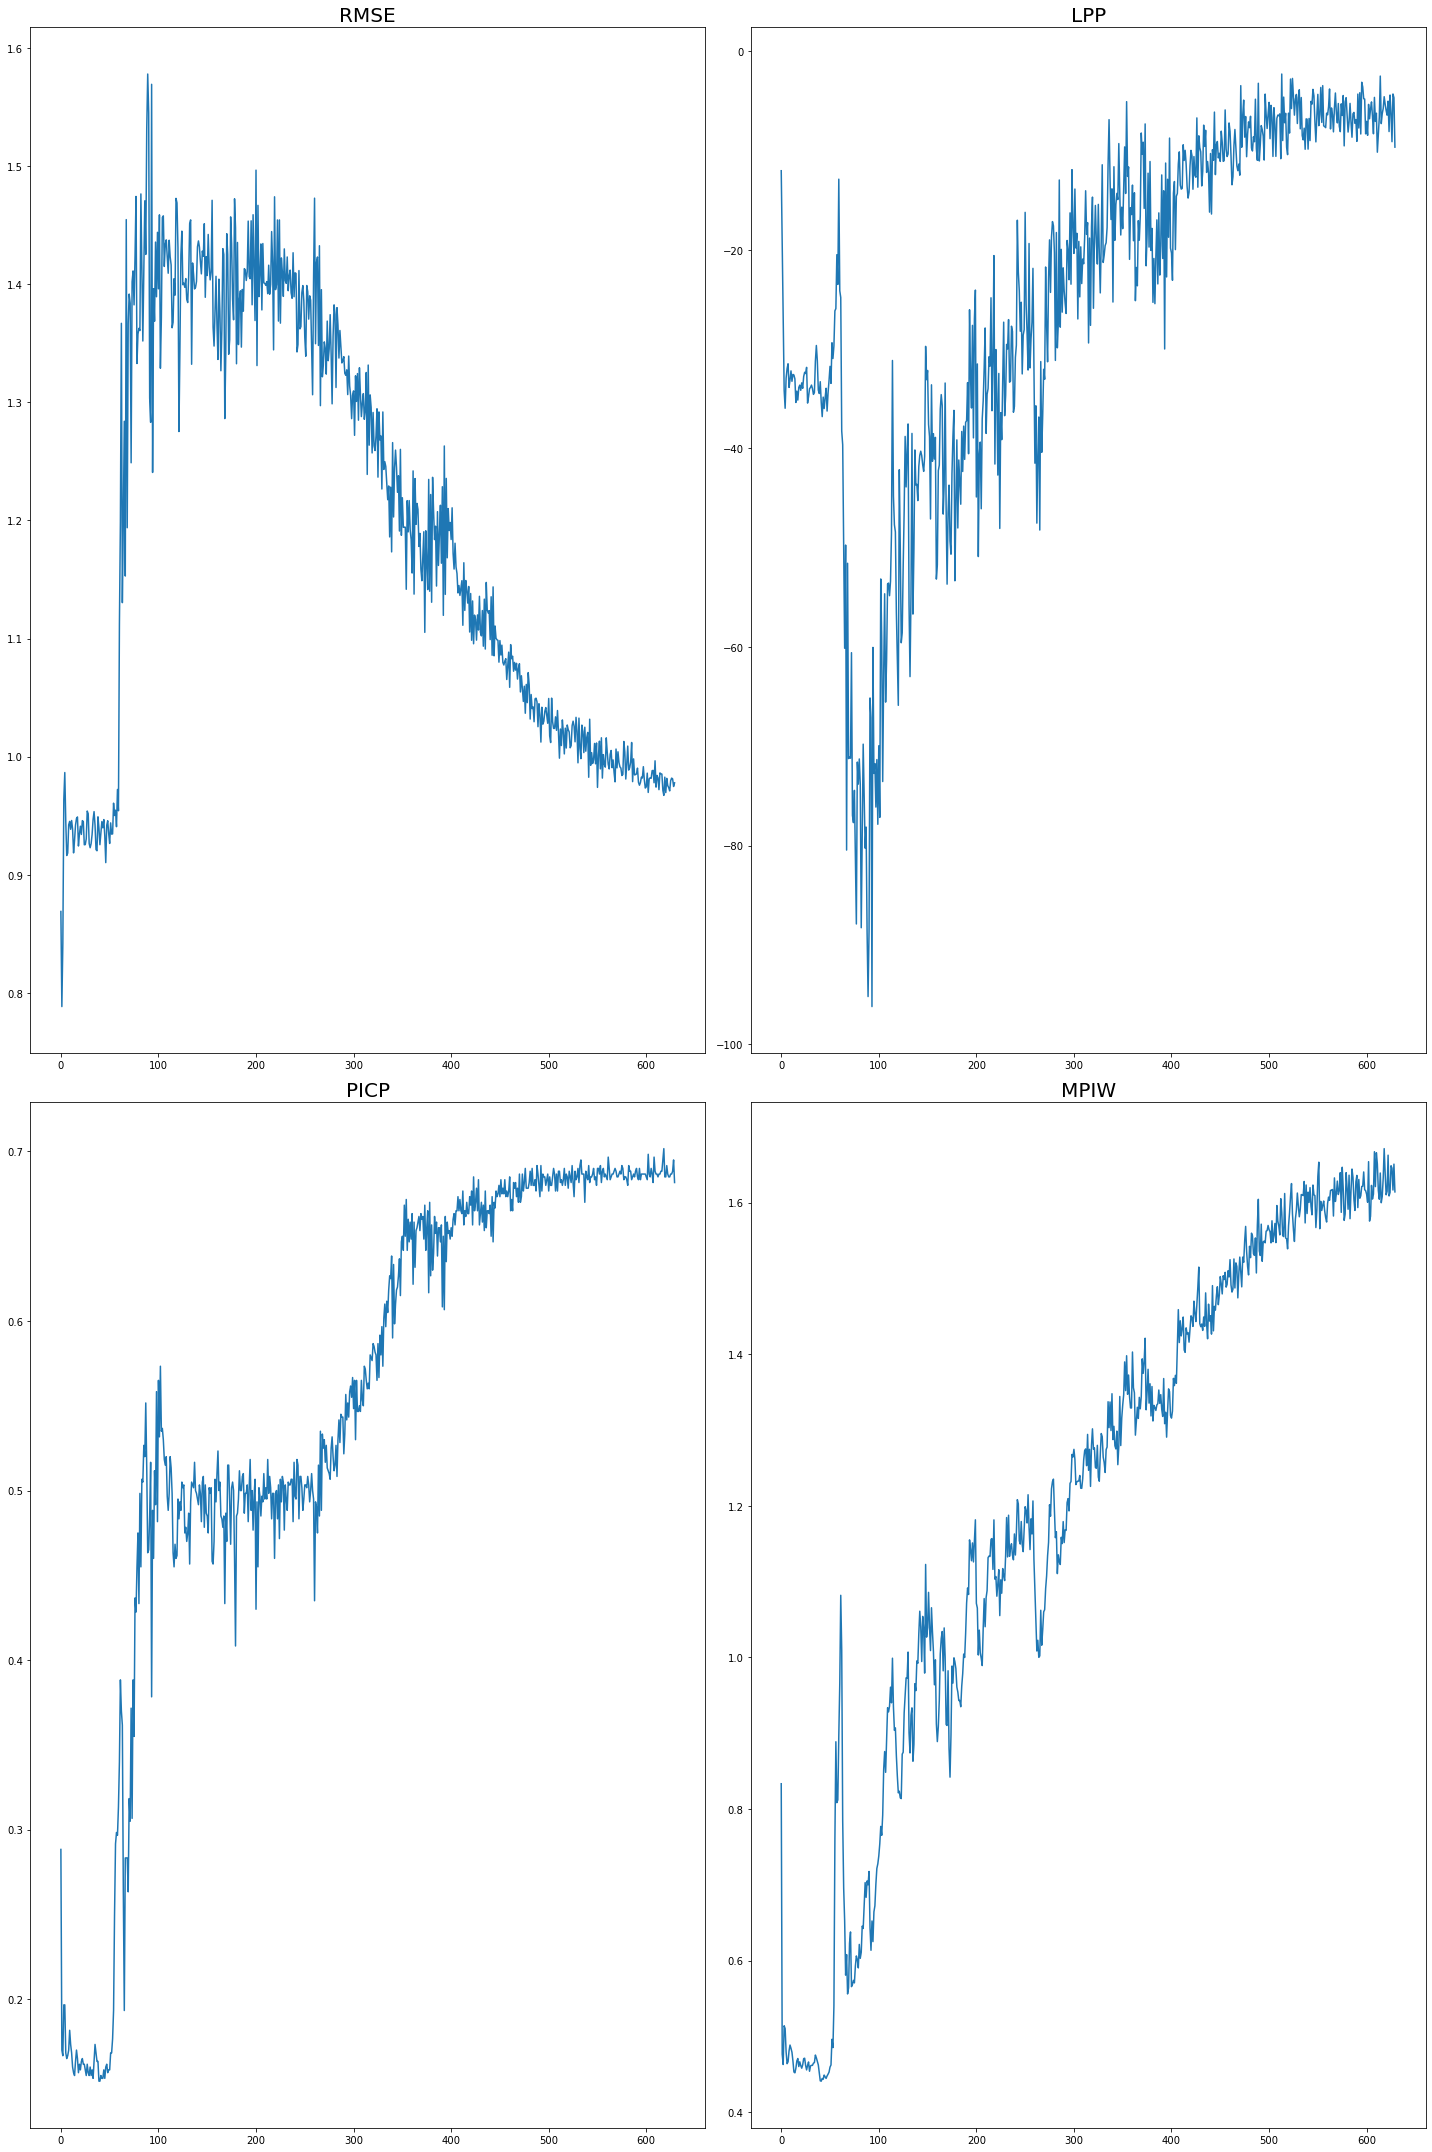

In [98]:
time_line=torch.arange(0,len(test_metrics['RMSE']),1)

for m,v in test_metrics.items():
    test_metrics[m]=torch.as_tensor(v)

fig, ax =plt.subplots(2,2, figsize=(20,30))
m='RMSE'
ax[0,0].plot(time_line,test_metrics[m])
ax[0,0].set_title(m, fontsize=20)
m='LPP'
ax[0,1].plot(time_line,test_metrics[m])
ax[0,1].set_title(m, fontsize=20)
m='PICP'
ax[1,0].plot(time_line,test_metrics[m])
ax[1,0].set_title(m, fontsize=20)
m='MPIW'
ax[1,1].plot(time_line,test_metrics[m])
ax[1,1].set_title(m, fontsize=20)
fig.tight_layout()

# Uncertainty vs error #

In [99]:
from torch.distributions import Uniform

sigma_noise_data = torch.tensor(0.1)
N = 25
M=100

X_l=Uniform(torch.tensor([-1.0]), torch.tensor([-.5])).sample(sample_shape=torch.Size([int(M)])).squeeze()
X_r=Uniform(torch.tensor([.5]), torch.tensor([1.0])).sample(sample_shape=torch.Size([int(M)])).squeeze()
X_in=torch.cat([X_l,X_r]).to(device)
X_middle=Uniform(torch.tensor([-.5]), torch.tensor([.5])).sample(sample_shape=torch.Size([int(200)])).squeeze().to(device)
X_l_=Uniform(torch.tensor([-2.0]), torch.tensor([-1.])).sample(sample_shape=torch.Size([int(M)])).squeeze()
X_r_=Uniform(torch.tensor([1.]), torch.tensor([2.])).sample(sample_shape=torch.Size([int(M)])).squeeze()
X_out=torch.cat([X_l_,X_r_]).to(device)

def f(X):
    y_ = torch.cos(4.0*(X+0.2)) 
    return y_ + sigma_noise_data* torch.randn_like(y_)

y_in=f(X_in).unsqueeze(-1)
y_middle=f(X_middle).unsqueeze(-1)
y_out=f(X_out).unsqueeze(-1)
print(X_in.shape, y_in.shape)

torch.Size([200]) torch.Size([200, 1])


In [118]:
import seaborn as sns
X=[X_in,X_middle,X_out]
y=[y_in,y_middle,y_out]
label=['in distribution', 'in between', 'out of distribution']

def Entropy(theta,k=1,k_MC=1,device='cpu'):
    """
    Parameters:
        theta (Tensor): Samples, Batch x N X D
        k (Int): ordinal number

    Returns:
        (Tensor) H of size B, with H[b] k-Nearest Neighbour Estimation of the entropy of theta[b,:,:]

    """
    nb_samples=theta.shape[-2]
    dim=theta.shape[-1]
    kMC=torch.tensor(float(k_MC))
    D=torch.cdist(theta,theta)
    print(D.shape)
    a = torch.topk(D, k=k+1, dim=-1, largest=False, sorted=True)[0][:,:,-1]
    print('a: {}'.format(a.shape))
    d=torch.as_tensor(float(dim), device=device)
    K=torch.as_tensor(float(k), device=device)
    N=torch.as_tensor(float(nb_samples), device=device)
    pi=torch.as_tensor(math.pi, device=device)
    lcd = d/2.*pi.log() - torch.lgamma(1. + d/2.0)#-d/2*K_MC.log()
    return torch.log(N) - torch.digamma(K) + lcd + d/nb_samples*a.div(torch.sqrt(kMC)).log().sum(-1)


Hs=[]
AEs=[]
for i in range(len(X)):
    theta=GeN(1000).detach()
    pred_=model(X[i],theta)
    pred=pred_+sigma_noise*torch.randn_like(pred_)

    print(X[i].shape)
    M = pred.shape[0]
    M_low = int(0.025 * M)
    M_high = int(0.975 * M)

    y_pred_s, _ = pred_.sort(dim=0)

    y_low = y_pred_s[M_low, :].squeeze().to(device)
    y_high = y_pred_s[M_high, :].squeeze().to(device)

    PIW=(std_y_train*(y_high-y_low))

    print(pred.shape)
    H=(Entropy(pred,k=20))
    print(H.shape)
    Hs.append(H)
    
    STD=(pred.std(0).squeeze())
    pred=model(X[i],theta)
    marginal_se=(pred-y[i])**2
    empirical_sqloss=marginal_se.mean()
    MSE=(std_y_train*(pred.mean(0).squeeze()-y[i].squeeze())**2)
    L1error=(std_y_train*(pred.mean(0).squeeze()-y[i].squeeze()).abs())
    AEs.append(L1error)
    ax=sns.scatterplot(H.cpu().numpy(),L1error.cpu().numpy(), label=label[i])
    
ax.set_ylabel('MSE')
ax.set_xlabel('Uncertainty (Diff Entropy)')



torch.Size([200])
torch.Size([1000, 200, 1])
torch.Size([1000, 200, 200])
a: torch.Size([1000, 200])
torch.Size([1000])


ValueError: arrays must all be same length

In [106]:
pred.shape


torch.Size([1000, 200, 1])

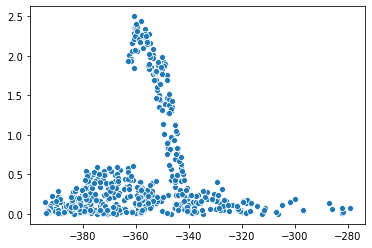

In [105]:
H_=torch.cat(Hs)
AE_=torch.cat(AEs)
sns.scatterplot(H_.cpu(),AE_.cpu())